In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
d = pd.read_csv('creditcard.csv')
d.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Проверим на дубликаты и пропуски

In [3]:
d.isna().values.any() or d.isnull().values.any()

False

In [4]:
d.duplicated().values.sum()

1081

Пропусков нет, удалим дубликаты

In [5]:
d.drop_duplicates(inplace=True)

Какие зависимости в данных? Построим матрицу корреляции

<Axes: >

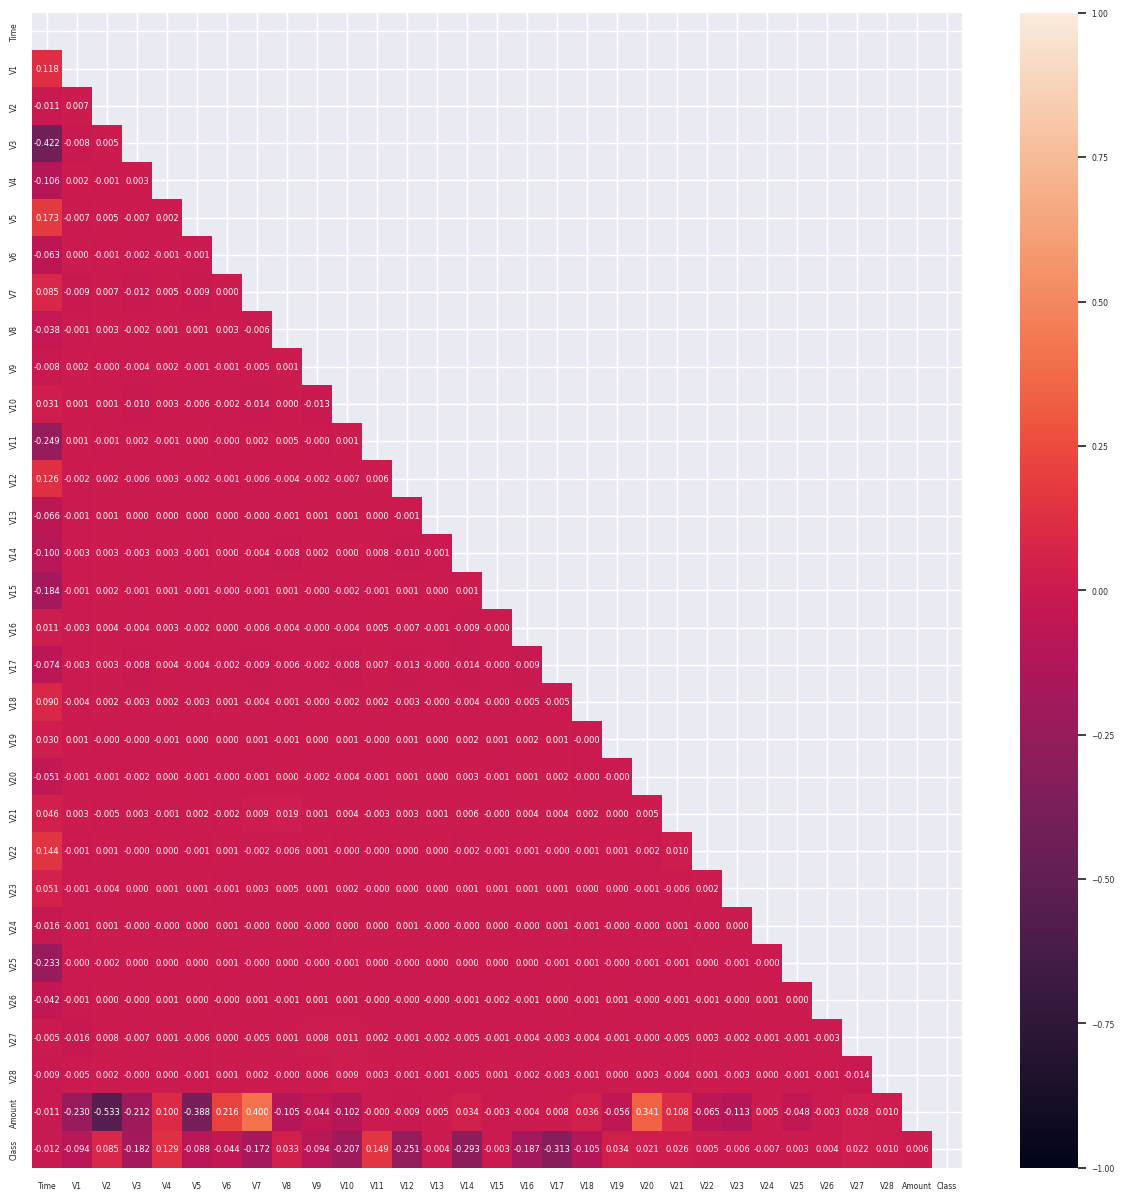

In [43]:
plt.figure(figsize=(15,15))
sns.set(font_scale=0.5)
corr_m = d.corr()
sns.heatmap(corr_m, annot=True,  fmt ='.3f', vmin=-1, vmax=1, mask=np.triu(corr_m))

Видим, что фичи V1-V28 слабо коррелируют между собой, при этом есть корреляции между целевой переменной Class и фичами V1-V28

In [45]:
d.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


Видим, что фичи Time и Amount значительно отличаются по порядку от фич V1-V28. 

In [52]:
d['Time'].value_counts()

3767.0      21
3770.0      20
19912.0     19
3750.0      19
73885.0     17
            ..
127732.0     1
62217.0      1
127739.0     1
127741.0     1
172792.0     1
Name: Time, Length: 124592, dtype: int64

Видим, что значение Time уникально для большей части строк в датасете

Сбалансирован ли датасет?

In [53]:
d['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

<Axes: xlabel='Class', ylabel='count'>

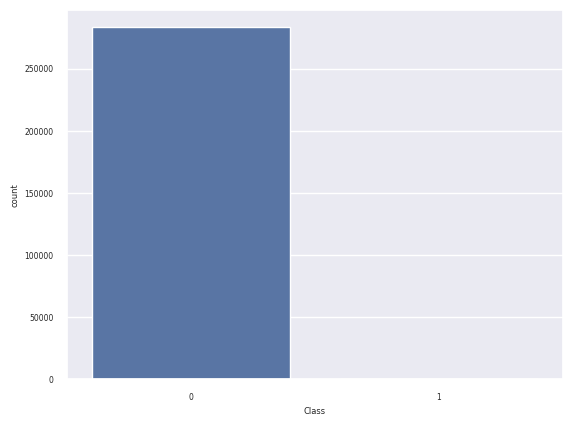

In [54]:
sns.countplot(d, x='Class')

Очевидно, датасет несбалансирован (фродовых транзакций меньше на 3 порядка)

Чтобы оценить зависимости в данных построим pairplot

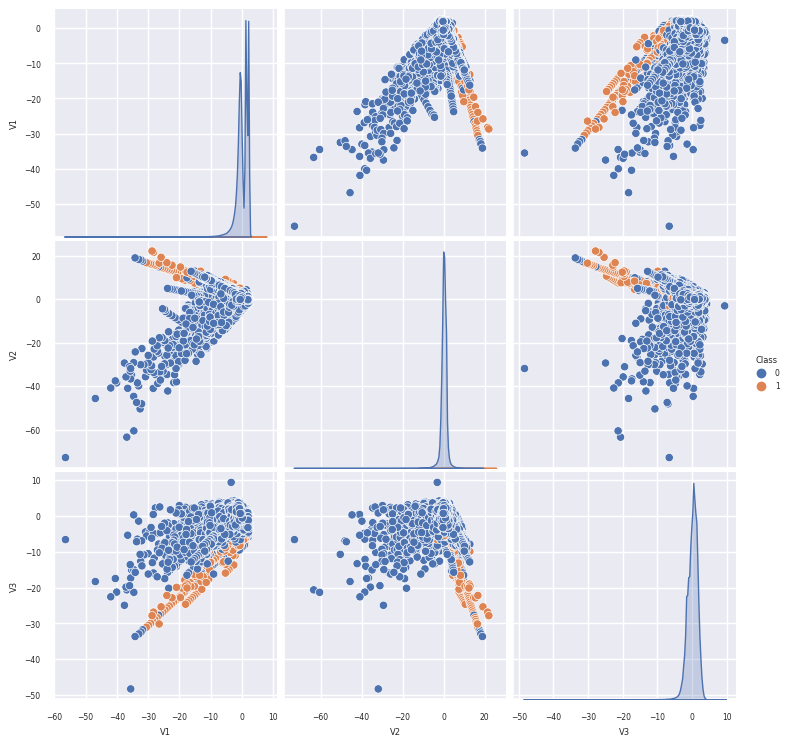

In [55]:
sns.pairplot(d[['V1', 'V2', 'V3', 'Class']], hue='Class')

In [56]:
X = d.drop(labels=['Class','Time', 'Amount'], axis=1)
y = d['Class']

Для разбиения на тестовую и обучающаю выборки учтем несбалансированность датасета (stratify по y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Проверим характеристики полученного разбиения

In [61]:
y.value_counts()

0    283253
1       473
Name: Class, dtype: int64

In [62]:
y_test.value_counts()

0    70814
1      118
Name: Class, dtype: int64

Видим, что соотношение числа элементов двух классов совпадает в тестовой и обучающей выборках

In [65]:
X_train.describe() - X_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,...,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000,141862.000000
mean,-0.004684,-0.006820,0.002280,0.010841,0.011494,0.001986,0.002518,0.001989,-0.007163,0.001137,...,0.005243,0.002520,0.004973,0.000277,-0.003425,0.001341,-0.000527,0.001033,0.000069,0.002570
std,-0.003924,0.020963,-0.012435,0.019864,-0.068305,-0.027531,-0.106279,-0.029010,-0.000001,-0.008740,...,0.004654,-0.035849,0.005113,-0.000171,0.009308,-0.000821,0.000633,-0.003432,-0.016974,-0.002474
min,-18.849443,-34.410417,14.644605,-0.266856,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,-3.639071,...,-2.594493,30.850830,-11.941035,-3.827154,-8.141735,-0.069989,-3.582773,-0.888910,-12.670435,3.719188
25%,0.000045,-0.003094,0.004602,0.005406,0.001863,0.001641,0.000519,0.000212,-0.003029,0.001811,...,0.002626,0.000777,-0.000017,0.003848,-0.001873,0.001165,-0.002484,0.002651,0.000422,0.000874
50%,-0.011334,0.000081,-0.007577,0.002061,0.004610,-0.002146,0.002906,0.000794,-0.004077,-0.000742,...,0.008418,0.000737,0.002730,0.003909,-0.001953,0.000669,-0.002065,0.003845,0.000055,0.000802
75%,-0.003124,0.006563,-0.000219,0.015847,0.011819,0.008231,0.007929,0.000019,-0.007609,0.010027,...,0.006988,0.001386,0.001369,0.001634,0.000314,0.001658,0.000548,-0.002334,0.001365,0.002349
max,0.015723,4.639080,5.280842,1.571160,1.890204,-51.908557,-86.286317,-0.419436,5.202106,10.100677,...,-0.019858,15.287010,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087


Для классификации будем использовать нелинейные модели KNN, Random Forest, HGBoost. Так как датасет несбалансированный, небходим предварительный этап при подготовке обучающего датасета. Будем использовать алгоритмы оверсэмплинга RandomOverSampling и SMOTE из imblearn. 

In [20]:
scalers = [
    ("Standard Scaler", StandardScaler())
]
samplers = [
    ("ROS", RandomOverSampler(random_state=17)), 
    ("SMOTE", SMOTE(random_state=17))
]
classifiers = [
    ("KNN", KNeighborsClassifier(n_jobs=-1, n_neighbors=3)),
    ("RandomForest", RandomForestClassifier(n_jobs=-1, random_state=17)),
    ("HGBoost", HistGradientBoostingClassifier(random_state=17))
]

Pipeline из imblearn автоматически применяет оверсэмлинг только к обучающей выборке на этапе .fit и не применяет на .predict, поэтому используем пайплайны

In [26]:
models = []
for scaler in scalers:
    for sampler in samplers:
        for clf in classifiers:
            name =  f"{scaler[0]} {sampler[0]} {clf[0]}"
            print(name)
            model = make_pipeline(scaler[1], sampler[1], clf[1])
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            report = classification_report(y_true=y_test, y_pred=y_pred)
            models.append((
                    name,
                    report,
                    model
                ))
            print(report)

Standard Scaler ROS KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.73      0.76      0.74       118

    accuracy                           1.00     70932
   macro avg       0.86      0.88      0.87     70932
weighted avg       1.00      1.00      1.00     70932

Standard Scaler ROS RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.94      0.74      0.82       118

    accuracy                           1.00     70932
   macro avg       0.97      0.87      0.91     70932
weighted avg       1.00      1.00      1.00     70932

Standard Scaler ROS HGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.85      0.78      0.81       118

    accuracy                           1.00     70932
   macro avg       0.93      0.89      0.91

В случае классификации фродовых операцией уместно ориентироваться на метрику F1. Видим,что лучший результат показывает RandomForest с оверсэмплингом ROS

In [30]:
models[1]

('Standard Scaler ROS RandomForest',
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     70814\n           1       0.94      0.74      0.82       118\n\n    accuracy                           1.00     70932\n   macro avg       0.97      0.87      0.91     70932\nweighted avg       1.00      1.00      1.00     70932\n',
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomoversampler', RandomOverSampler(random_state=17)),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_jobs=-1, random_state=17))]))

Займемся подбором гиперпараметров

In [31]:
params = {
    "randomforestclassifier__n_estimators": (50, 75, 100),
    "randomforestclassifier__max_depth": (3, 5, 10)
}

На кросс-валидации используем StratifiedKFold, чтобы учесть несбалансированность датасета

In [35]:
gcv = GridSearchCV(estimator=models[1][2], param_grid=params, refit='recall', n_jobs=-1, cv=StratifiedKFold(n_splits=3))


In [36]:
gcv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomoversampler',
                                        RandomOverSampler(random_state=17)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=17))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': (3, 5, 10),
                         'randomforestclassifier__n_estimators': (50, 75, 100)},
             refit='recall')

In [66]:
gcv.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 75}

In [40]:
clf = gcv.best_estimator_
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.76      0.99      0.86       118

    accuracy                           1.00     70932
   macro avg       0.88      1.00      0.93     70932
weighted avg       1.00      1.00      1.00     70932



Получили, что модель Random Forest + Random Over Sampler добилась на кроссвалидации recall=0.99 и precision=0.76, что является лучшим результатом.